# Distribution of maximum for 1-D posterior example (RBF covariance)

> Investigation into the distribution of the maximum for a 1-D toy example.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from dolfin import *
import numpy as np
import numba
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.cm as cm
# plt.rcParams['figure.figsize'] = (10,6)
from scipy.stats import multivariate_normal, linregress
from scipy import integrate
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.linalg import sqrtm
from scipy.interpolate import interp1d
import sympy; sympy.init_printing()
from tqdm import tqdm
# code for displaying matrices nicely
def display_matrix(m):
    display(sympy.Matrix(m))
# import required functions from oneDim
from statFEM_analysis.oneDim import mean_assembler, cov_assembler, kernMat, m_post, gen_sensor, MyExpression, m_post_fem_assembler, c_post, c_post_fem_assembler, sample_gp

Let's first import the `wass` function created in the sub-module `maxDist`.

In [3]:
from statFEM_analysis.maxDist import wass

## Sampling from true maxiumum distribution in 1D

We will be interested in the toy example introduced in <a href="/statFEM/oneDim.html#1-dimensional-case-(ODE)"><code>oneDim</code></a>, however we will use different values for the parameters in the distribution of $f$. To obtain a sample for the maximum from the true posterior we must first sample trajectories from the true posterior.

In [4]:
# set up mean and kernel functions
l_f = 0.01
σ_f = 0.1

@numba.jit
def m_f(x):
    return 1.0

@numba.jit
def c_f(x,y):
    return (σ_f**2)*np.exp(-(x-y)**2/(2*(l_f**2)))

# translation invariant form of c_f
@numba.jit
def k_f(x):
    return (σ_f**2)*np.exp(-(x**2)/(2*(l_f**2)))

# mean of forcing for use in FEniCS
f_bar = Constant(1.0)

# true prior solution mean
μ_true = Expression('0.5*x[0]*(1-x[0])',degree=2)

In [5]:
# set up true prior cov function for solution
# compute inner integral over t
def η(w,y):
    I_1 = integrate.quad(lambda t: t*c_f(w,t),0.0,y)[0]
    I_2 = integrate.quad(lambda t: (1-t)*c_f(w,t),y,1.0)[0]
    return (1-y)*I_1 + y*I_2

# use this function eta and compute the outer integral over w
def c_u(x,y):
    I_1 = integrate.quad(lambda w: (1-w)*η(w,y),x,1.0)[0]
    I_2 = integrate.quad(lambda w: w*η(w,y),0.0,x)[0]
    return x*I_1 + (1-x)*I_2

We will also need a function `u_quad` to accurately compute the solution for a given realisation of $f$ in order to generate sensor data. This is set up below:

In [6]:
def u_quad(x,f,maxiter=50):
    I_1 = integrate.quadrature(lambda w: w*f(w), 0.0, x,maxiter=maxiter)[0]
    I_2 = integrate.quadrature(lambda w: (1-w)*f(w),x, 1.0,maxiter=maxiter)[0]
    return (1-x)*I_1 + x*I_2

We now set up a reference grid on which we will simulate trajectories. We take a grid of length $N = 41$.

In [7]:
N = 41
grid = np.linspace(0,1,N)

We now set up the sensor grid and the true prior covariance on this sensor grid which will be needed in all further computations. We also set up the function which gives the vector $\{c_u(x,y_i)\}_{i=1}^{s}$ needed for the posterior.

In [8]:
s = 10 # number of sensors
# create sensor grid
Y = np.linspace(0.01,0.99,s)[::-1] 
# get true prior covariance on sensor grid
C_true_s = kernMat(c_u,Y.flatten())
# create function to compute vector mentioned above
def c_u_vect(x):
    return np.array([c_u(x,y_i) for y_i in Y])

We now set up a function to get the statFEM prior and posterior for a FE mesh of size $h$, using functions from <a href="/statFEM/oneDim.html#"><code>oneDim</code></a>.

In [9]:
# set up function to compute fem_prior
def fem_prior(h,f_bar,k_f,grid):
    J = int(np.round(1/h))
    μ = mean_assembler(h,f_bar)
    Σ = cov_assembler(J,k_f,grid,False,True)
    return μ,Σ

In [10]:
# set up function to compute statFEM posterior
def fem_posterior(h,f_bar,k_f,ϵ,Y,v_dat,grid):
    J = int(np.round(1/h))
    m_post_fem = m_post_fem_assembler(J,f_bar,k_f,ϵ,Y,v_dat)
    μ = MyExpression()
    μ.f = m_post_fem
    Σ = c_post_fem_assembler(J,k_f,grid,Y,ϵ,False,True)
    return μ,Σ

Let's see how different levels of sensor noise change the statFEM posterior from the statFEM prior.

In [11]:
ϵ_list = [0.0001,0.0005,0.001,0.01]

In [12]:
h = 0.05
μ_prior, Σ_prior = fem_prior(h,f_bar,k_f,grid)
posteriors = {}
sensor_dat = {}
np.random.seed(12345)
for ϵ in ϵ_list:
    v_dat = gen_sensor(ϵ,m_f,k_f,Y,u_quad,grid,maxiter=400)
    sensor_dat[ϵ] = v_dat
    μ_posterior, Σ_posterior = fem_posterior(h,f_bar,k_f,ϵ,Y,v_dat,grid)
    posteriors[ϵ] = (μ_posterior,Σ_posterior)

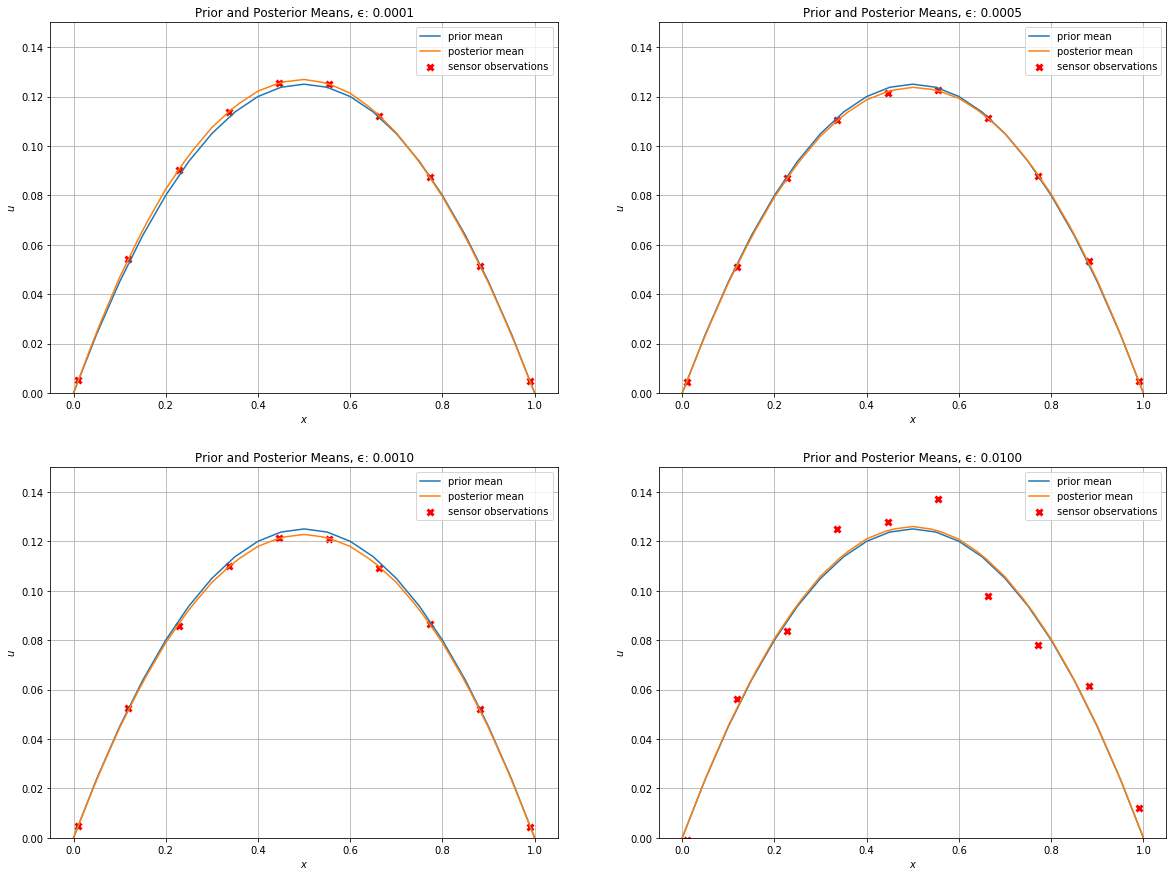

In [13]:
plt.figure(figsize=(20,15))
J_plot = 50
for (i,ϵ) in enumerate(ϵ_list):
    μ_posterior, Σ_posterior = posteriors[ϵ]
    v_dat = sensor_dat[ϵ]
    plt.subplot(2,2,i + 1)
    plot(μ_prior,mesh=UnitIntervalMesh(J_plot),label='prior mean')
    plot(μ_posterior,mesh=UnitIntervalMesh(J_plot),label='posterior mean')
    plt.scatter(Y,v_dat,c='red',linewidth=3,marker='x',label='sensor observations')
    plt.grid()
    plt.xlabel("$x$")
    plt.ylabel("$u$")
    plt.ylim(0,0.15)
    plt.title('Prior and Posterior Means, ϵ: %.4f' % ϵ)
    plt.legend()
plt.show()

Let's also plot the prior covariances next to the posterior covariances

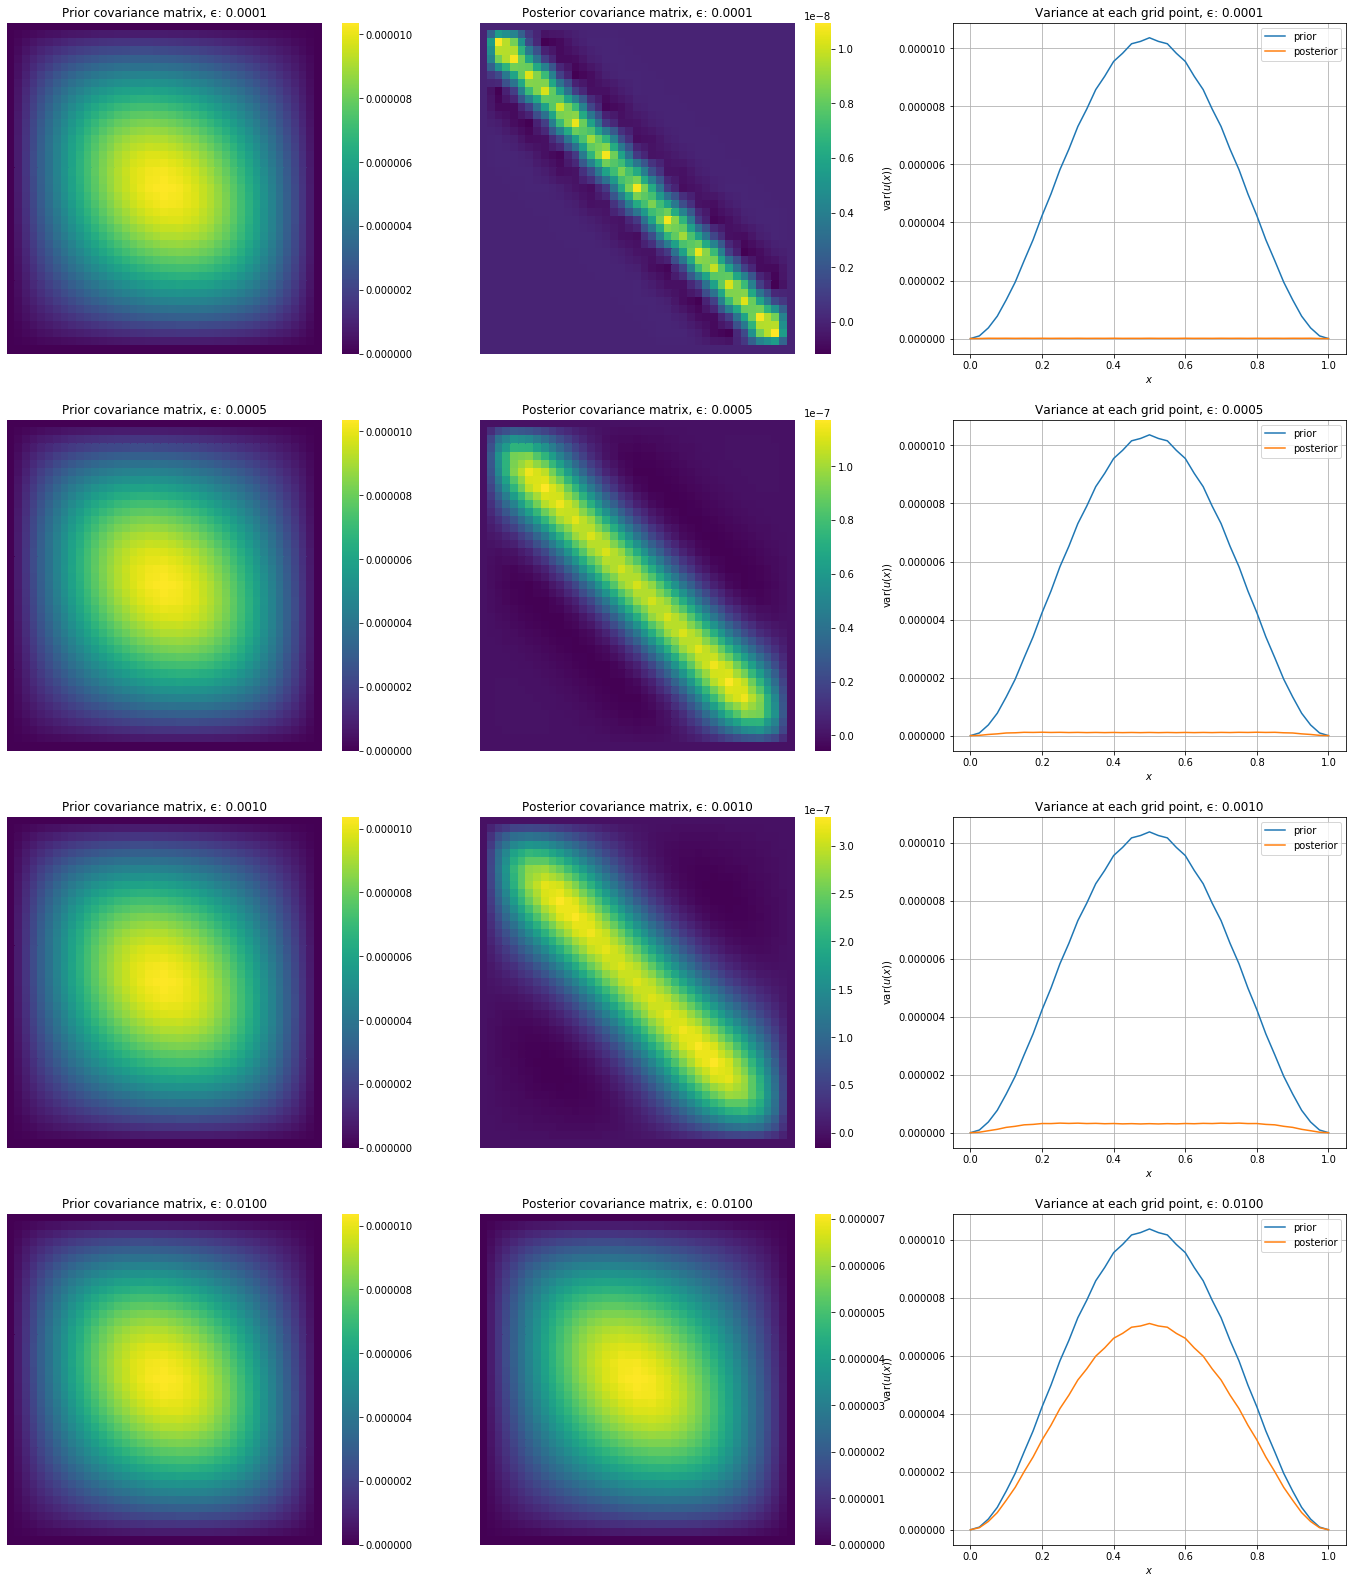

In [14]:
fig, axs = plt.subplots(4,3,figsize=(24,28))
for (i,ϵ) in enumerate(ϵ_list):
    μ_posterior, Σ_posterior = posteriors[ϵ]
    sns.heatmap(Σ_prior,cbar=True,
              annot=False,
              xticklabels=False,
              yticklabels=False,
              cmap=cm.viridis,
              ax=axs[i,0])
    axs[i,0].set_title('Prior covariance matrix, ϵ: %.4f' % ϵ)\
    
    sns.heatmap(Σ_posterior,cbar=True,
                  annot=False,
                  xticklabels=False,
                  yticklabels=False,
                  cmap=cm.viridis,
                  ax=axs[i,1])
    axs[i,1].set_title('Posterior covariance matrix, ϵ: %.4f' % ϵ)
    
    axs[i,2].plot(grid,np.diag(Σ_prior),label='prior')
    axs[i,2].plot(grid,np.diag(Σ_posterior),label='posterior')
    axs[i,2].grid()
    axs[i,2].set_xlabel('$x$')
    axs[i,2].set_ylabel('$\operatorname{var}(u(x))$')
    axs[i,2].set_title('Variance at each grid point, ϵ: %.4f' % ϵ)
    axs[i,2].legend()
plt.show()

Let's now consider a particular example to see if the code works and also to calibrate the number of bins. We now generate sensor data and set up the true posterior mean and covariance functions.

In [15]:
# sensor noise level
ϵ = ϵ_list[2]
print('ϵ: ',ϵ)
np.random.seed(235)
v_dat = gen_sensor(ϵ,m_f,k_f,Y,u_quad,grid,maxiter=300)

# get true B mat required for posterior
B_true = (ϵ**2)*np.eye(s) + C_true_s

# set up true posterior mean
def true_mean(x):
    return m_post(x,μ_true,c_u_vect,v_dat,Y,B_true)

# set up true posterior covariance
def c_post_true(x,y):
    return c_post(x,y,c_u,Y,B_true)

ϵ:  0.001


We now sample trajectories from the true posterior and plot these.

In [16]:
%%time
n_sim = 1000
np.random.seed(12345)
u_sim = sample_gp(n_sim, true_mean, c_post_true, grid,True,False)

CPU times: user 5.31 s, sys: 6.1 ms, total: 5.31 s
Wall time: 1min 18s


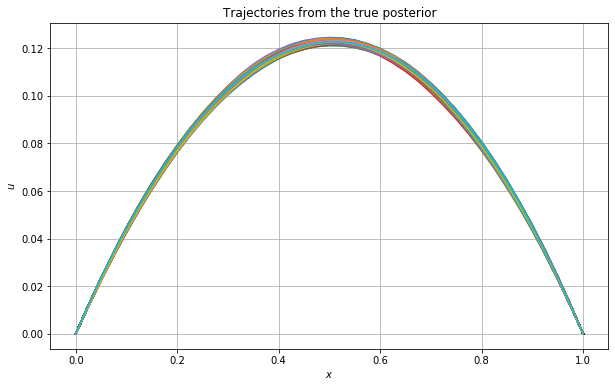

In [17]:
#hide_input
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(grid,u_sim)
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Trajectories from the true posterior')
plt.grid()
plt.show()

Let's now get the maximum value for each simulated curve and store this in a variable `max_true` for future use. We plot the histogram for these maximum values.

In [18]:
max_true = u_sim.max(axis=0)

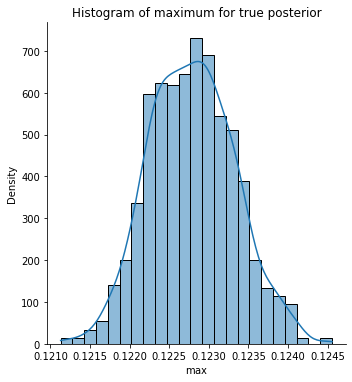

In [20]:
sns.displot(max_true,kde=True,stat="density")
plt.xlabel('$\max$')
plt.title('Histogram of maximum for true posterior')
plt.show()

## Sampling from statFEM posterior maxiumum distribution in 1D

We now create a function to utilise FEniCS to draw trajectories from the statFEM posterior.

In [21]:
def statFEM_posterior_sampler(n_sim, grid, h, f_bar, k_f, ϵ, Y, v_dat, par = False, trans = True, tol = 1e-9):
    # get length of grid
    d = len(grid)
    
    # get size of FE mesh
    J = int(np.round(1/h))
    
    # get statFEM posterior mean function
    m_post_fem = m_post_fem_assembler(J,f_bar,k_f,ϵ,Y,v_dat)
    μ_func = MyExpression()
    μ_func.f = m_post_fem
    
    # evaluate this on the grid
    μ = np.array([μ_func(x) for x in grid]).reshape(d,1)
    
    # get statFEM posterior cov mat on grid
    Σ = c_post_fem_assembler(J,k_f,grid,Y,ϵ,False,True)
    
    # construct the cholesky decomposition Σ = GG^T
    # we add a small diagonal perturbation to Σ to ensure it
    # strictly positive definite
    G = np.linalg.cholesky(Σ + tol * np.eye(d))

    # draw iid standard normal random vectors
    Z = np.random.normal(size=(d,n_sim))

    # construct samples from GP(m,k)
    Y = G@Z + np.tile(μ,n_sim)

    # return the sampled trajectories
    return Y

Let's test this function out by using it to obtain samples from the statFEM posterior for a particular value of $h$.

In [22]:
%%time
h = 0.1
np.random.seed(3542)
u_sim_statFEM = statFEM_posterior_sampler(n_sim, grid, h, f_bar, k_f, ϵ, Y, v_dat)

CPU times: user 115 ms, sys: 10 ms, total: 125 ms
Wall time: 119 ms


Let's plot the above trajectories.

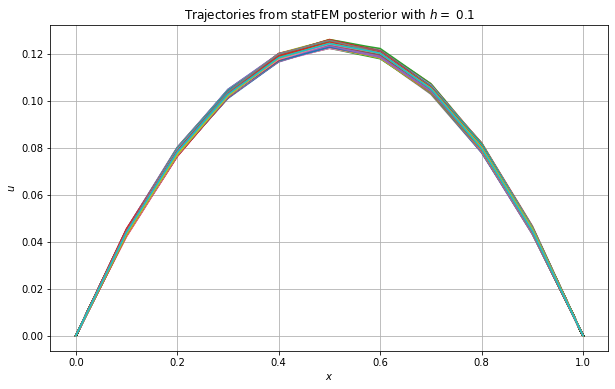

In [23]:
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(grid,u_sim_statFEM)
plt.grid()
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Trajectories from statFEM posterior with $h = $ %0.1f' % h)
plt.show()

Let's now get the maximum value for each simulated curve and store this in a variable `max_statFEM` for future use. We then plot the histograms for these maximum values together with those from the true posterior.

In [24]:
max_statFEM = u_sim_statFEM.max(axis=0)

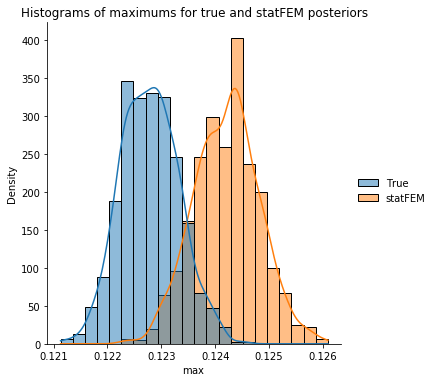

In [26]:
max_data = pd.DataFrame(data={'True': max_true, 'statFEM': max_statFEM})
sns.displot(max_data,kde=True,stat="density")
plt.xlabel('$\max$')
plt.title('Histograms of maximums for true and statFEM posteriors')
plt.show()

Our `wass` function requires the number of bins to be specified. Let's investigate how varying this parameter affects the computed distance between the true maximums and our statFEM maximums.

In [27]:
n_bins = np.arange(10,200,10)
wass_bin_dat = [wass(max_true,max_statFEM,n) for n in n_bins]

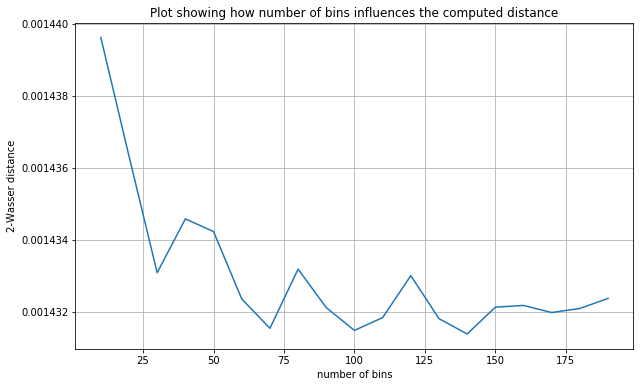

In [28]:
plt.plot(n_bins,wass_bin_dat)
plt.grid()
plt.xlabel('number of bins')
plt.ylabel('2-Wasser distance')
plt.title('Plot showing how number of bins influences the computed distance')
plt.show()

From the plot above we see that the distance seems to stabilize after around $100$ bins. We choose to take `n_bins=150` for the rest of this example.

We now set up a range of $h$-values to use for the statFEM posterior.

In [29]:
# set up range of h values to use
h_range_tmp = np.linspace(0.25,0.02,100)
h_range = 1/np.unique(np.round(1/h_range_tmp))
np.round(h_range,2)

array([0.25, 0.2 , 0.17, 0.14, 0.12, 0.11, 0.1 , 0.09, 0.08, 0.08, 0.07,
       0.07, 0.06, 0.06, 0.06, 0.05, 0.05, 0.05, 0.05, 0.04, 0.04, 0.04,
       0.04, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02])

We now loop over these $h$-values, and for each value we simulate maximums from the statFEM posterior and then compute the 2-Wasserstein distance between these maximums and those from the true posterior.

In [30]:
%%time
errors = []
###################
n_bins = 150
##################
np.random.seed(3252)
for h in tqdm(h_range):
    # sample trajectories from statFEM prior for current h value
    sim = statFEM_posterior_sampler(n_sim, grid, h, f_bar, k_f, ϵ, Y, v_dat)
    # get max
    max_sim = sim.max(axis=0)
    # compute error
    error = wass(max_true,max_sim,n_bins)
    # append to errors
    errors.append(error)

100%|██████████| 30/30 [00:02<00:00, 14.67it/s]

CPU times: user 2.06 s, sys: 7.08 ms, total: 2.07 s
Wall time: 2.05 s


In [32]:
errors = np.array(errors)

We see that as $h$ decreases so too does the distance/error. Let's investigate the rate by plotting this data in log-log space and then estimating the slope of the line of best fit.

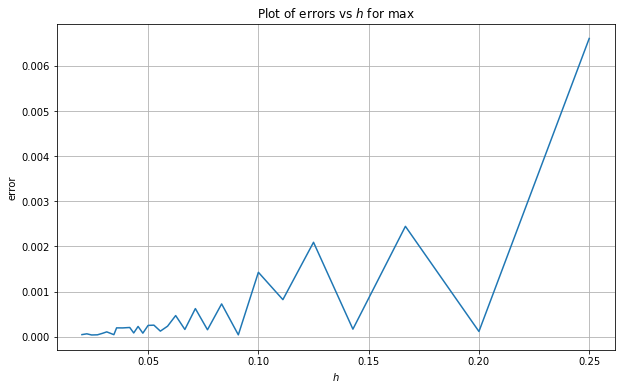

In [33]:
plt.plot(h_range,errors)
plt.grid()
plt.xlabel('$h$')
plt.ylabel('error')
plt.title('Plot of errors vs $h$ for $\max$')
plt.show()

We see that as $h$ decreases so too does the distance/error. Let's investigate the rate by plotting this data in log-log space and then estimating the slope of the line of best fit.

slope: 1.417570    intercept: -4.420736    r value: 0.717469     p value: 0.000008


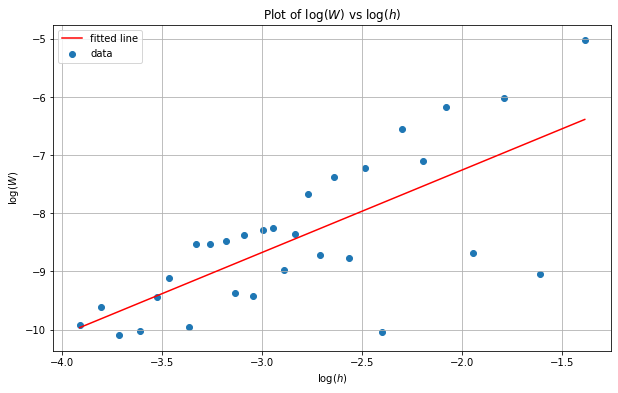

In [34]:
#hide_input
log_h_range = np.log(h_range)
log_errors = np.log(errors)

# perform linear regression to get line of best fit for the log scales:
lm = linregress(log_h_range,log_errors)
print("slope: %f    intercept: %f    r value: %f     p value: %f" % (lm.slope, lm.intercept, lm.rvalue, lm.pvalue))

# plot line of best fit with the data:
x = np.linspace(np.min(log_h_range),np.max(log_h_range),100)
plt.scatter(log_h_range,log_errors,label='data')
plt.plot(x,lm.intercept + lm.slope * x, 'r', label='fitted line')
plt.grid()
plt.legend()
plt.xlabel('$\log(h)$')
plt.ylabel('$\log(W)$')
plt.title('Plot of $\log(W)$ vs $\log(h)$')
plt.show()

We can see from the above plot that the slope is around $1.42$ - this differs from our theory showing the results for the $\max$ are out of the remit of our theory.

We now repeat the above for different levels of sensor noise.

In [35]:
results = {}

In [36]:
%%time
np.random.seed(345346)
tol = 1e-10
n_sim = 1000
for ϵ in tqdm(ϵ_list,desc='Eps loop'):
    # generate sensor data
    v_dat = gen_sensor(ϵ,m_f,k_f,Y,u_quad,grid,maxiter=400)
    # get true B mat required for posterior
    B_true = (ϵ**2)*np.eye(s) + C_true_s

    # set up true posterior mean
    def true_mean(x):
        return m_post(x,μ_true,c_u_vect,v_dat,Y,B_true)
    
    # set up true posterior covariance
    def c_post_true(x,y):
        return c_post(x,y,c_u,Y,B_true)
    
    u_sim = sample_gp(n_sim, true_mean, c_post_true, grid,True,False)
    
    max_true = u_sim.max(axis=0)
    
    errors = []
    
    for h in tqdm(h_range):
        # sample trajectories from statFEM prior for current h value
        sim = statFEM_posterior_sampler(n_sim, grid, h, f_bar, k_f, ϵ, Y, v_dat)
        # get max
        max_sim = sim.max(axis=0)
        # compute error
        error = wass(max_true,max_sim,n_bins)
        # append to errors
        errors.append(error)
        
    results[ϵ] = (errors,u_sim)

Eps loop: 100%|██████████| 4/4 [05:42<00:00, 85.56s/it]

CPU times: user 35.9 s, sys: 200 ms, total: 36.1 s
Wall time: 5min 42s


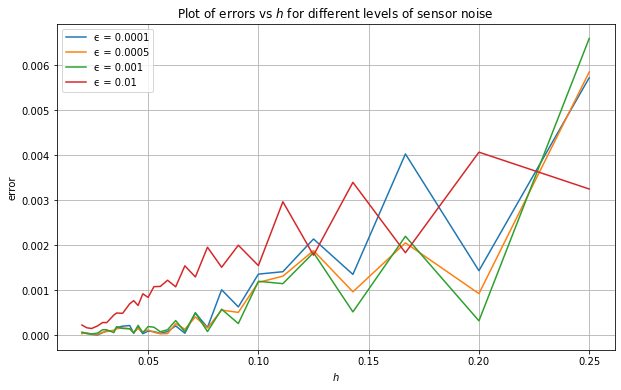

In [37]:
plt.plot()
plt.grid()
plt.xlabel('$h$')
plt.ylabel('error')
plt.title('Plot of errors vs $h$ for different levels of sensor noise')
for ϵ in ϵ_list:
    errors = results[ϵ][0]
    plt.plot(h_range,errors, label = 'ϵ = ' + str(ϵ))
plt.legend()
plt.show()

ϵ: 0.00010,    slope: 2.1862,    intercept: -2.3203
ϵ: 0.00050,    slope: 1.9552,    intercept: -3.0104
ϵ: 0.00100,    slope: 1.6573,    intercept: -3.7885
ϵ: 0.01000,    slope: 1.3131,    intercept: -3.2989


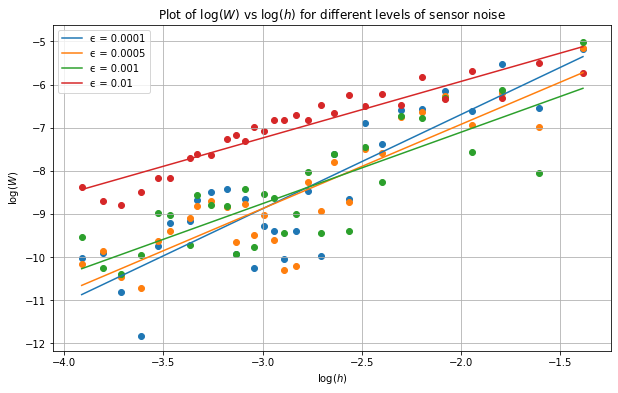

In [38]:
#hide_input
plt.plot()
plt.grid()
plt.xlabel('$\log(h)$')
plt.ylabel('$\log(W)$')
plt.title('Plot of $\log(W)$ vs $\log(h)$ for different levels of sensor noise')
log_h_range = np.log(h_range)
for ϵ in ϵ_list:
    errors = results[ϵ][0]
    log_errors = np.log(errors)
    lm = linregress(log_h_range,log_errors)
    print('ϵ: %.5f,    slope: %.4f,    intercept: %.4f' % (ϵ, lm.slope,lm.intercept))
    plt.scatter(log_h_range,log_errors)
    plt.plot(x,lm.intercept + lm.slope * x, label='ϵ = ' +str(ϵ))
plt.legend()
plt.show()

We can see from these results that for we obtain different results for the rates. In particular, we observe the rate increasing from $1.3$ when $\epsilon=0.01$ up to around $2.2$ when $\epsilon$ decreases to $0.0001$. Thus, for small values of sensor noise we obtain rates similar to the case of linear quantities of interest. This is potentially do to the fact that for small levels of sensor noise the posterior trajectories concentrate and so the maximum is almost always located at the maximum of the true prior mean. Thus, we come to the regime where taking the maximum is the same as point evaluation, which is a linear functional.